In [22]:
import numpy as np
import datetime
import os
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.stats import chi
from scipy import stats
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential


############
# Functions
############

# Our 3d parameter space is the surface of a sphere centered at (1, 1, 1), with radius 1/sqrt(2)
# x, y coordinates are the x and y variances of our 2d Gaussian
# z coordinate determines the x-coordinate of the mean, mu = (z, 0)

def mean_gen(theta, phi):
    mu = 0.5 + (np.sqrt(2)/2) * np.cos(phi + np.pi / 4)
    return mu


def varx_gen(theta, phi):
    vx = 1.5 - (np.sqrt(2)/2) * np.cos(theta + np.pi / 4) * np.sin(phi + np.pi / 2)
    return vx


def vary_gen(theta, phi):
    vy = 1.5 - (np.sqrt(2)/2) * np.sin(theta + np.pi / 4) * np.sin(phi + np.pi / 2)
    return vy


# Generate n data
def spherical_data(n, thetas, phis, rand=1234):
    
    mx1, my1 = np.zeros(n), np.zeros(n)
    vx1, vy1 = np.ones(n), np.ones(n)
    
    mx2, my2 = mean_gen(thetas, phis), np.zeros(n)
    vx2, vy2 = varx_gen(thetas, phis), vary_gen(thetas, phis)
    
    x1, y1 = np.transpose(np.array([np.random.normal(mx1, vx1, size=n), 
                                    np.random.normal(my1, vy1, size=n), thetas, phis])), np.zeros(n)
    x2, y2 = np.transpose(np.array([np.random.normal(mx2, vx2, size=n), 
                                    np.random.normal(my2, vy2, size=n), thetas, phis])), np.ones(n)
    
    x, y = np.append(x1, x2, axis=0), np.append(y1, y2, axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = rand)
    
    return x_train, x_test, y_train, y_test

In [23]:
# Single Point on Sphere

n = 40000
rand_n = 12345
theta, phi = 5, 3
thetas, phis = theta * np.ones(n), phi * np.ones(n)
x_train, x_test, y_train, y_test = spherical_data(n, thetas, phis, rand_n)

In [4]:
# Loading Models

names = []
names.append('discrete_model_mth6_mph5')
names.append('discrete_model_mth3_mph3')
names.append('discrete_model_mth2_mph2')
names.append('discrete_model_mth1_mph1')
l = len(names)

models = []
predictions = []
for i in range(l):
    models.append(tf.keras.models.load_model('3dmodels/' + names[i]))
    predictions.append(models[i](x_test).numpy())

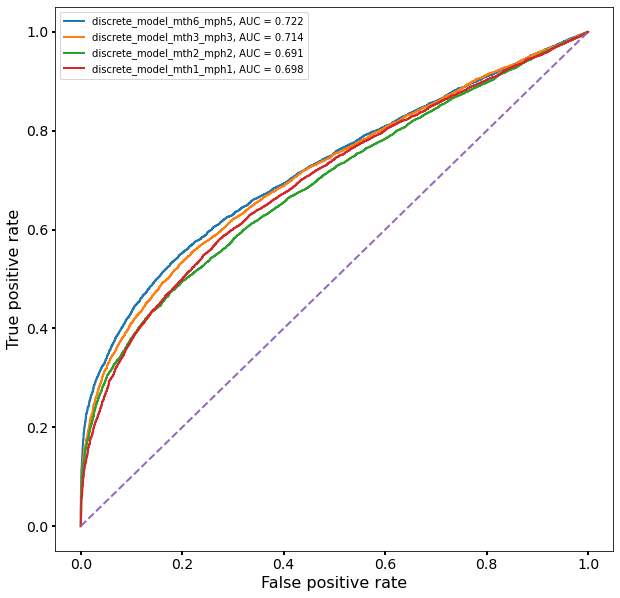

In [5]:
fig, ax1 = plt.subplots(figsize=(10,10))
fontsize=16
minor_size=14

for i in range(l):
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, predictions[i])
    auc = sklearn.metrics.auc(fpr, tpr)
    ax1.plot(fpr, tpr, lw=2, label=names[i] + ', AUC = %.3f' % (auc))

ax1.set_xlabel("Score")
ax1.plot([0, 1], [0, 1], '--', lw=2)
ax1.set_xlabel('False positive rate', fontsize=fontsize)
ax1.set_ylabel('True positive rate', fontsize=fontsize)
# ax1.set_title('Models on Theta = %.1f Data' % (theta), fontsize=fontsize)
ax1.legend()
ax1.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)

In [24]:
model = models[0]

for l in model.layers:
    l.trainable=False
    
    
inputs_hold = tf.keras.Input(shape=(1,))
simple_model = Dense(1, use_bias = False)(inputs_hold)
model3 = Model(inputs = inputs_hold, outputs = simple_model)

inputs = tf.keras.Input(shape=(1,))
inputs2 = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)), inputs, inputs])
hidden_layer_1 = model(inputs2)
model2 = Model(inputs = inputs, outputs = hidden_layer_1)
model2.compile(loss='categorical_crossentropy', optimizer='Adam', )

In [27]:
for i in range(50):
    #better to make a custom callback
    model2.fit(x_train, y_train, epochs=1,batch_size=100)
    print(i,"Fitted result: ", model2.trainable_weights[0].numpy()[0][0])

ValueError: Creating variables on a non-first call to a function decorated with tf.function.